In [1]:
### Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import helper as my


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import pairwise
from sklearn.cluster import KMeans

from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import mean_squared_error

### Get the data
NBAdata, draftData = my.getData()
# draftData = draftData[:100]

In [2]:
### define the columns we want
clusteringCols = ['FT%', '3P%', 'eFG%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 'STL%', 'BLK%', 'USG%', 'OWS', 'DWS', 
                  'FTA', '3PA', 'PTS', 'PF', 'MP_per_PF', 'FTA_per_FGA', 'MP_per_3PA', 'PTS_per_FGA', 
                  'C', 'F', 'G', 'PPM', 'PPG', 'HEIGHT', 'WEIGHT']

x_cols = ['gamesPlayed', 'minutes', 'FT%', '3P%', 'SOS', 'PER', 'eFG%', 'ORB%', 'DRB%', 'AST%', 'TOV%', 
          'STL%', 'BLK%', 'USG%','OWS', 'DWS', 'FTA', 'FGA', 'MP', '3PA', 'PTS', 'PF', 'MP_per_PF', 'PPG', 
          'PPM','FTA_per_FGA', 'MP_per_3PA', 'PTS_per_FGA', "AST_per_TOV", 'ORtg', 'DRtg','awards','RSCI', 
          'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'SHUTTLE_RUN','THREE_QUARTER_SPRINT', 'STANDING_VERTICAL', 
          'MAX_VERTICAL','BENCH_PRESS', 'BODY_FAT', 'HAND_LENGTH', 'HAND_WIDTH', "didCombine", 
          'HEIGHT_W_SHOES', 'REACH', 'WEIGHT', 'WINGSPAN', 'C', 'F', 'G']
target = "WM"
allCols = list(dict.fromkeys(clusteringCols + x_cols)) # removes duplicates
draftOnlyCols = [col for col in allCols if col not in clusteringCols]


scaler = StandardScaler()
# scaler = MinMaxScaler()

scaledNBA, scaledDraft = NBAdata.copy(), draftData.copy()
scaledNBA[clusteringCols] = scaler.fit_transform(scaledNBA[clusteringCols])
scaledDraft[clusteringCols] = scaler.transform(scaledDraft[clusteringCols])
scaledDraft[draftOnlyCols] = scaler.fit_transform(scaledDraft[draftOnlyCols])

In [3]:
### Do the clustering
n_clusters =  3

fittedCluster = KMeans(n_clusters=n_clusters).fit(scaledNBA[clusteringCols].values)
scaledNBA['label'] = fittedCluster.labels_
scaledDraft['label'] = fittedCluster.predict(scaledDraft[clusteringCols].values, sample_weight=None)

In [8]:
# Create a function that will get features for all draftees for each team
metricCols = clusteringCols
metric = "euclidean"
metric_function = pairwise.distance_metrics()[metric]
n_players = 5
nba_features = ['dist_avg', "dist_dot_min", "dist_dot_WS", "min_dist", "label_count",
                'label_dist_avg', "label_dist_dot_min", "label_dist_dot_WS", "label_min_dist"
               ]
def getTeamFeatures(draftee):
    draftYear = draftee["Year"]
    nbaYear = scaledNBA[scaledNBA["Year"]==draftYear-1]
    thisYearsTeams = nbaYear["Tm"].unique()
    preds = pd.DataFrame({"Team":thisYearsTeams})
    for col in nba_features: preds[col] = np.nan
    
    for i in range(len(preds)):
        nbaTeamName = preds["Team"].iloc[i]
        fullnbaTeam = nbaYear[nbaYear["Tm"]==nbaTeamName].sort_values(by=["MP"])
        labelTeam = fullnbaTeam[fullnbaTeam['label']==draftee["label"]]
        teamSize, labelSize = len(fullnbaTeam), len(labelTeam)
        
        nbaTeam = fullnbaTeam.iloc[:n_players] if teamSize>=n_players else fullnbaTeam
        
        distances = np.array([metric_function(draftee[metricCols].to_numpy().reshape(1,-1), 
                                     nbaTeam[metricCols].iloc[i][metricCols].to_numpy().reshape(1,-1)).item()
                     for i in range(len(nbaTeam))])
        label_distances = np.array([metric_function(draftee[metricCols].to_numpy().reshape(1,-1), 
                                     labelTeam[metricCols].iloc[i][metricCols].to_numpy().reshape(1,-1)).item()
                     for i in range(len(labelTeam))])
        # Turn them into a feature vector
        preds.iloc[i,preds.columns.get_loc("dist_avg")] = np.mean(distances)
        preds.iloc[i,preds.columns.get_loc("dist_std")] = np.std(distances)
        preds.iloc[i,preds.columns.get_loc("dist_dot_min")] = np.dot(1./distances, nbaTeam["MP"].values)
        preds.iloc[i,preds.columns.get_loc("dist_dot_WS")] = np.dot(1./distances, nbaTeam["MP"].values)
        preds.iloc[i,preds.columns.get_loc("min_dist")] = np.min(distances)
        
        preds.iloc[i,preds.columns.get_loc("label_count")] = labelSize/teamSize
        if False: #len(label_distances) != 0:
            preds.iloc[i,preds.columns.get_loc("label_dist_avg")] = np.mean(label_distances)
            preds.iloc[i,preds.columns.get_loc("label_dist_std")] = np.std(label_distances)
            preds.iloc[i,preds.columns.get_loc("label_dist_dot_min")] = np.dot(1./label_distances,
                                                                               labelTeam["MP"].values)
            preds.iloc[i,preds.columns.get_loc("label_dist_dot_WS")] = np.dot(1./label_distances, 
                                                                              labelTeam["MP"].values)
            preds.iloc[i,preds.columns.get_loc("label_min_dist")] = np.min(label_distances)
        
    # Do some quick mean imputation if there are missing values
    for col in nba_features:
        preds[col] = preds[col].fillna(np.mean(preds[col]))
        
    return preds
        
# Create a dictionary containing {draftee name:team features df}
# teamFeatures = {}
# for i in range(len(scaledDraft)):
#     draftee = scaledDraft.iloc[i]
#     drafteeName = draftee["Player"]
#     teamFeatures[drafteeName] = getTeamFeatures(draftee)
    
#     # Do some mean imputation on the missing values
    
#     print("{}/{} completed!".format(i+1, len(scaledDraft)))
teamFeatures = np.load("/home/nrowe/Thesis/Model/teamFeatures_2.npy", allow_pickle=True).tolist()

In [9]:
# Scale these new features
allTeamFeatures = [0 for i in range(len(teamFeatures.keys()))]
# Combine them to create one scaler
for i, key in enumerate(teamFeatures.keys()): 
    allTeamFeatures[i] = teamFeatures[key]
    
allTeamFeatures = pd.concat(allTeamFeatures)
scaler = StandardScaler()
scaler.fit(allTeamFeatures[nba_features])

for i, key in enumerate(teamFeatures.keys()): 
    teamFeatures[key][nba_features] = scaler.transform(teamFeatures[key][nba_features])

# Change what our training subset looks like 
allCols = list(dict.fromkeys(allCols)) # removes duplicate
trainingCols = allCols + nba_features

In [10]:
# Add the actual features (for training the model) to the overall dataset
for col in nba_features: scaledDraft[col] = np.nan
for i in range(len(scaledDraft)):
    key = scaledDraft.iloc[i]["Player"]
    tm = scaledDraft.iloc[i]["Tm"]
    featuresDF = teamFeatures[key]
    for col in nba_features:
        value = featuresDF[featuresDF["Team"]==tm][col]
        scaledDraft.iloc[i, scaledDraft.columns.get_loc(col)] = featuresDF[featuresDF["Team"]==tm][col].values[0]

In [11]:
## NEURAL NETWORK MODEL
def create_NN():
    N, epochs, batch_size = len(trainingCols), 20, 20
    def create_model():
        model = Sequential()
        model.add(Dense(N, input_dim=N, kernel_initializer='normal', activation='sigmoid'))
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer="Adam")
        return model
    return KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)


## RANDOM FOREST MODEL
def create_RF():
    params = {"n_estimators":1, "n_jobs":16}
    return RandomForestRegressor(**params)

from sklearn.neighbors import KNeighborsRegressor
def create_KNN():
    params = {"n_neighbors":15}
    return KNeighborsRegressor(**params)

In [12]:
## Split the data into X and Y
draftX, draftY = scaledDraft[trainingCols], scaledDraft[target]

## Set up oversampling (only affects draft data I think)
oversampledX, oversampledY = draftX.copy(), draftY.copy()
highValue = 3
highDraftX, highDraftY = oversampledX[oversampledY > highValue], oversampledY[oversampledY > highValue]
lowValue = 0.1
lowDraftX, lowDraftY = oversampledX[oversampledY < lowValue], oversampledY[oversampledY < lowValue]
middleRowNum = len(draftX) - len(highDraftX) - len(lowDraftX)

# Number of samples is equal to size of subset
for i in range(0):
    addRow = np.random.randint(len(highDraftX))
    oversampledX = oversampledX.append(highDraftX.iloc[addRow])
    oversampledY = oversampledY.append(pd.Series(highDraftY.iloc[addRow], index=[highDraftY.index[addRow]]))
    
# for i in range(len(lowDraftX)):
# for i in range(middleRowNum):
for i in range(0):
    addRow = np.random.randint(len(lowDraftX))
    oversampledX = oversampledX.append(lowDraftX.iloc[addRow])
    oversampledY = oversampledY.append(pd.Series(lowDraftY.iloc[addRow], index=[lowDraftY.index[addRow]]))  

# oversampledX.reset_index(inplace=True, drop=True)
# oversampledY.reset_index(inplace=True, drop=True)

In [13]:
# Do the actual loop to get predicted values
loo = LeaveOneOut()
preds = pd.DataFrame(index=scaledDraft.index, columns=["WM_pred"])

model = create_RF()
for _, test_index in loo.split(draftX):

    # Split the data according to the oversampling
    # X_test, Y_test = draftX.loc[test_index[0]:test_index[0]], draftY.loc[test_index[0]:test_index[0]]
    X_test, Y_test = draftX.iloc[test_index[0]:test_index[0]+1], draftY.iloc[test_index[0]:test_index[0]+1]
    # X_test, Y_test = draftX.loc[test_index], draftY.loc[test_index]
    X_train = oversampledX.drop([test_index[0]], axis=0, inplace=False)
    Y_train = oversampledY.drop([test_index[0]], axis=0, inplace=False)
    
    # Make sure no occurances of test in training
    X_train = X_train[X_train.index!=X_test.index.values[0]]
    Y_train = Y_train[X_train.index!=X_test.index.values[0]]
    
    # Convert the input to tensors
    # X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    # Y_train = tf.convert_to_tensor(Y_train, dtype=tf.float32)
    old_X_test = X_test
    # X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    
    # Generate the model
    model.fit(X_train, Y_train)
    preds["WM_pred"].iloc[test_index] = model.predict(X_test)
    
    # Now we use that trained model to make predictions on all of the team combinations
    key = scaledDraft.loc[test_index]["Player"].values[0]
    teamFeaturesDic = teamFeatures[key]
    teamFeaturesDic['WM_pred'] = np.nan

    targetColLoc = teamFeaturesDic.columns.get_loc("WM_pred")
    for i in range(len(teamFeaturesDic)):
        team = teamFeaturesDic.iloc[i]["Team"]
        teamData = teamFeaturesDic.iloc[i:i+1][nba_features]
        # Merge it with the other features
        for col in allCols: 
            teamData[col] = old_X_test[col].values[0]

        # Do the predictions
        teamFeaturesDic.iloc[i, targetColLoc] = model.predict(teamData)
        
    teamFeatures[key] = teamFeaturesDic
    
    print("{}/{} complete! ({})".format(test_index[0]+1, len(draftX), key))
    
scaledDraft = pd.concat([scaledDraft, preds], axis=1, sort=False)
datatypes = {"WM_pred":float}
scaledDraft = scaledDraft.astype(datatypes)

1/655 complete! (markellefultz)
2/655 complete! (lonzoball)
3/655 complete! (jaysontatum)
4/655 complete! (joshjackson)
5/655 complete! (deaaronfox)
6/655 complete! (jonathanisaac)
7/655 complete! (laurimarkkanen)
8/655 complete! (dennissmith)
9/655 complete! (zachcollins)
10/655 complete! (malikmonk)
11/655 complete! (lukekennard)
12/655 complete! (donovanmitchell)
13/655 complete! (bamadebayo)
14/655 complete! (justinpatton)
15/655 complete! (djwilson)
16/655 complete! (tjleaf)
17/655 complete! (johncollins)
18/655 complete! (harrygiles)
19/655 complete! (jarrettallen)
20/655 complete! (oganunoby)
21/655 complete! (tylerlydon)
22/655 complete! (calebswanigan)
23/655 complete! (kylekuzma)
24/655 complete! (tonybradley)
25/655 complete! (derrickwhite)
26/655 complete! (joshhart)
27/655 complete! (frankjackson)
28/655 complete! (davonreed)
29/655 complete! (frankmason)
30/655 complete! (ivanrabb)
31/655 complete! (jonahbolden)
32/655 complete! (semiojeleye)
33/655 complete! (jordanbell)

254/655 complete! (robertsacre)
255/655 complete! (kyrieirving)
256/655 complete! (derrickwilliams)
257/655 complete! (tristanthompson)
258/655 complete! (brandonknight)
259/655 complete! (kembawalker)
260/655 complete! (jimmerfredette)
261/655 complete! (klaythompson)
262/655 complete! (alecburks)
263/655 complete! (markieffmorris)
264/655 complete! (marcusmorris)
265/655 complete! (kawhileonard)
266/655 complete! (nikolavucevic)
267/655 complete! (imanshumpert)
268/655 complete! (chrissingleton)
269/655 complete! (tobiasharris)
270/655 complete! (nolansmith)
271/655 complete! (kennethfaried)
272/655 complete! (reggiejackson)
273/655 complete! (marshonbrooks)
274/655 complete! (jordanhamilton)
275/655 complete! (jajuanjohnson)
276/655 complete! (norriscole)
277/655 complete! (coryjoseph)
278/655 complete! (jimmybutler)
279/655 complete! (justinharper)
280/655 complete! (kylesingler)
281/655 complete! (shelvinmack)
282/655 complete! (tylerhoneycutt)
283/655 complete! (jordanwilliams)
2

505/655 complete! (joeygraham)
506/655 complete! (dannygranger)
507/655 complete! (hakimwarrick)
508/655 complete! (juliushodge)
509/655 complete! (naterobinson)
510/655 complete! (jarrettjack)
511/655 complete! (franciscogarcia)
512/655 complete! (lutherhead)
513/655 complete! (jasonmaxiell)
514/655 complete! (linaskleiza)
515/655 complete! (davidlee)
516/655 complete! (salimstoudamire)
517/655 complete! (danielewing)
518/655 complete! (ronnyturiaf)
519/655 complete! (travisdiener)
520/655 complete! (vonwafer)
521/655 complete! (braceywright)
522/655 complete! (ryangomes)
523/655 complete! (oriengreene)
524/655 complete! (dijonthompson)
525/655 complete! (alexacker)
526/655 complete! (bengordon)
527/655 complete! (devinharris)
528/655 complete! (joshchildress)
529/655 complete! (luoldeng)
530/655 complete! (rafaelaraujo)
531/655 complete! (andreiguodala)
532/655 complete! (lukejackson)
533/655 complete! (krishumphries)
534/655 complete! (kirksnyder)
535/655 complete! (jameernelson)
53

WM MSE: 4.224777542173217


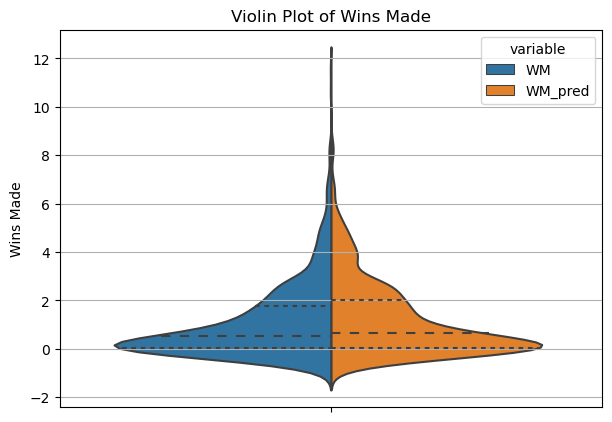

In [14]:
# Calculate some of the errors

print("WM MSE: {}".format(mean_squared_error(scaledDraft.loc[scaledDraft["WM"].isnull()==False]["WM"], 
                                             preds.loc[scaledDraft["WM"].isnull()==False]["WM_pred"], 
                                             squared=True)))

# Some plotting of these
import seaborn as sns

plt.figure(figsize=(7,5), dpi=100)
plt.title("Violin Plot of Wins Made")
plt.grid()
plotData = scaledDraft[["WM", "WM_pred"]].melt().assign(x="")
sns.violinplot(data=plotData, x="x", y="value", hue="variable", inner="quartile", split=True)
plt.ylabel("Wins Made")
plt.xlabel("")
plt.show()


In [15]:
# Define a function to grab the next best pick for a team
def getHighestPred(data, team):
    playerNames = data['Player']
    bestName, bestProj = None, -100
    for name in playerNames:
        playerProjs = teamFeatures[name]
        proj = playerProjs[playerProjs["Team"]==team]["WM_pred"].values[0]
        
        if proj > bestProj:
            bestName = name
    
    return bestName
PICKCOUNT = 0
# Create a mock draft to evaluate how many wins are gained
scaledDraft.rename(columns={"Pk":"overallPick"}, inplace=True)
simData = pd.DataFrame(columns=["team", "oldPick", "newPick", "year"])
ALL_TEAMS = scaledDraft["Tm"].unique()
for year in np.unique(scaledDraft["Year"]):
    if year > 2016:
        continue
    yearDraftData = scaledDraft[scaledDraft["Year"]==year]
    yearNBAData = scaledNBA[scaledNBA["Year"]==year]
    yearDraftData.sort_values(by=["overallPick"], inplace=True)
    picks, teams = yearDraftData["overallPick"].to_numpy(), yearDraftData["Tm"].to_numpy()
    picks, teams = picks[~pd.isnull(picks)], teams[~pd.isnull(picks)]
    
    for myTeam in ALL_TEAMS:
        print("YEAR: {}, TEAM: {}".format(year, myTeam))
        oldPicks = yearDraftData.loc[yearDraftData["Tm"]==myTeam]["Player"].to_numpy() # These are players
        myPicks = yearDraftData.loc[yearDraftData["Tm"]==myTeam]['overallPick'].to_numpy() # These are numbers
        alreadyPicked = []
        myActualPicks = []
        
        # Figure out what the new picks will be
        for pick in picks:
            avalPicks = yearDraftData[~yearDraftData.Player.isin(alreadyPicked)]
            if pick in myPicks:
                # Choose highest remaining target value
                # myPick = getHighestPred(avalPicks, myTeam)
                myPick = avalPicks.loc[avalPicks["WM_pred"]==max(avalPicks["WM_pred"])]["Player"].iloc[0]
                PICKCOUNT += 1
                alreadyPicked.append(myPick)
                myActualPicks.append(myPick)
            else:
                minPick = min(avalPicks['overallPick'])
                theirPick = avalPicks.loc[avalPicks['overallPick']==minPick]["Player"].iloc[0]
                alreadyPicked.append(theirPick)
                
        if len(np.unique(myActualPicks))!=len(myActualPicks):
            print("ERROR")
            
        for i in range(len(myPicks)):
            teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
            teamSeries["year"] = year
            teamSeries["team"] = myTeam
            teamSeries["oldPick"] = oldPicks[i]
            teamSeries["newPick"] = myActualPicks[i]
            teamSeries['overallPick'] = myPicks[i]
            
            simData = simData.append(teamSeries, ignore_index=True)
            

<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2000, TEAM: PHI
YEAR: 2000, TEAM: LAL
YEAR: 2000, TEAM: BOS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2000, TEAM: PHO
YEAR: 2000, TEAM: SAC
YEAR: 2000, TEAM: ORL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2000, TEAM: MIN
YEAR: 2000, TEAM: DAL
YEAR: 2000, TEAM: CHO


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2000, TEAM: DET
YEAR: 2000, TEAM: DEN
YEAR: 2000, TEAM: MIA


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2000, TEAM: CHI
YEAR: 2000, TEAM: MIL
YEAR: 2000, TEAM: IND
YEAR: 2000, TEAM: ATL
YEAR: 2000, TEAM: POR
YEAR: 2000, TEAM: BRK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2000, TEAM: TOR
YEAR: 2000, TEAM: UTA
YEAR: 2000, TEAM: SAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2000, TEAM: NOP
YEAR: 2000, TEAM: NYK
YEAR: 2000, TEAM: HOU


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2000, TEAM: LAC
YEAR: 2000, TEAM: GSW
YEAR: 2000, TEAM: OKC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2000, TEAM: WAS
YEAR: 2000, TEAM: CLE
YEAR: 2000, TEAM: MEM


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2001, TEAM: PHI
YEAR: 2001, TEAM: LAL
YEAR: 2001, TEAM: BOS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2001, TEAM: PHO
YEAR: 2001, TEAM: SAC
YEAR: 2001, TEAM: ORL
YEAR: 2001, TEAM: MIN


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2001, TEAM: DAL
YEAR: 2001, TEAM: CHO
YEAR: 2001, TEAM: DET


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2001, TEAM: DEN
YEAR: 2001, TEAM: MIA
YEAR: 2001, TEAM: CHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2001, TEAM: MIL
YEAR: 2001, TEAM: IND
YEAR: 2001, TEAM: ATL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2001, TEAM: POR
YEAR: 2001, TEAM: BRK
YEAR: 2001, TEAM: TOR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2001, TEAM: UTA
YEAR: 2001, TEAM: SAS
YEAR: 2001, TEAM: NOP
YEAR: 2001, TEAM: NYK
YEAR: 2001, TEAM: HOU
YEAR: 2001, TEAM: LAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2001, TEAM: GSW
YEAR: 2001, TEAM: OKC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2001, TEAM: WAS
YEAR: 2001, TEAM: CLE
YEAR: 2001, TEAM: MEM


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2002, TEAM: PHI
YEAR: 2002, TEAM: LAL
YEAR: 2002, TEAM: BOS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2002, TEAM: PHO
YEAR: 2002, TEAM: SAC
YEAR: 2002, TEAM: ORL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2002, TEAM: MIN
YEAR: 2002, TEAM: DAL
YEAR: 2002, TEAM: CHO


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2002, TEAM: DET
YEAR: 2002, TEAM: DEN
YEAR: 2002, TEAM: MIA
YEAR: 2002, TEAM: CHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2002, TEAM: MIL
YEAR: 2002, TEAM: IND
YEAR: 2002, TEAM: ATL
YEAR: 2002, TEAM: POR
YEAR: 2002, TEAM: BRK
YEAR: 2002, TEAM: TOR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2002, TEAM: UTA
YEAR: 2002, TEAM: SAS
YEAR: 2002, TEAM: NOP


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2002, TEAM: NYK
YEAR: 2002, TEAM: HOU
YEAR: 2002, TEAM: LAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2002, TEAM: GSW
YEAR: 2002, TEAM: OKC
YEAR: 2002, TEAM: WAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

YEAR: 2002, TEAM: CLE
YEAR: 2002, TEAM: MEM
YEAR: 2003, TEAM: PHI
YEAR: 2003, TEAM: LAL
YEAR: 2003, TEAM: BOS
YEAR: 2003, TEAM: PHO


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2003, TEAM: SAC
YEAR: 2003, TEAM: ORL
YEAR: 2003, TEAM: MIN


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2003, TEAM: DAL
YEAR: 2003, TEAM: CHO
YEAR: 2003, TEAM: DET
YEAR: 2003, TEAM: DEN


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2003, TEAM: MIA
YEAR: 2003, TEAM: CHI
YEAR: 2003, TEAM: MIL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2003, TEAM: IND
YEAR: 2003, TEAM: ATL
YEAR: 2003, TEAM: POR
YEAR: 2003, TEAM: BRK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2003, TEAM: TOR
YEAR: 2003, TEAM: UTA
YEAR: 2003, TEAM: SAS
YEAR: 2003, TEAM: NOP
YEAR: 2003, TEAM: NYK
YEAR: 2003, TEAM: HOU
YEAR: 2003, TEAM: LAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2003, TEAM: GSW
YEAR: 2003, TEAM: OKC
YEAR: 2003, TEAM: WAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

YEAR: 2003, TEAM: CLE
YEAR: 2003, TEAM: MEM
YEAR: 2004, TEAM: PHI
YEAR: 2004, TEAM: LAL
YEAR: 2004, TEAM: BOS
YEAR: 2004, TEAM: PHO
YEAR: 2004, TEAM: SAC
YEAR: 2004, TEAM: ORL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2004, TEAM: MIN
YEAR: 2004, TEAM: DAL
YEAR: 2004, TEAM: CHO
YEAR: 2004, TEAM: DET
YEAR: 2004, TEAM: DEN
YEAR: 2004, TEAM: MIA
YEAR: 2004, TEAM: CHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2004, TEAM: MIL
YEAR: 2004, TEAM: IND
YEAR: 2004, TEAM: ATL
YEAR: 2004, TEAM: POR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2004, TEAM: BRK
YEAR: 2004, TEAM: TOR
YEAR: 2004, TEAM: UTA
YEAR: 2004, TEAM: SAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2004, TEAM: NOP
YEAR: 2004, TEAM: NYK
YEAR: 2004, TEAM: HOU
YEAR: 2004, TEAM: LAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2004, TEAM: GSW
YEAR: 2004, TEAM: OKC
YEAR: 2004, TEAM: WAS
YEAR: 2004, TEAM: CLE


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)


YEAR: 2004, TEAM: MEM
YEAR: 2005, TEAM: PHI
YEAR: 2005, TEAM: LAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2005, TEAM: BOS
YEAR: 2005, TEAM: PHO
YEAR: 2005, TEAM: SAC
YEAR: 2005, TEAM: ORL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2005, TEAM: MIN
YEAR: 2005, TEAM: DAL
YEAR: 2005, TEAM: CHO
YEAR: 2005, TEAM: DET
YEAR: 2005, TEAM: DEN
YEAR: 2005, TEAM: MIA


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2005, TEAM: CHI
YEAR: 2005, TEAM: MIL
YEAR: 2005, TEAM: IND


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2005, TEAM: ATL
YEAR: 2005, TEAM: POR
YEAR: 2005, TEAM: BRK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2005, TEAM: TOR
YEAR: 2005, TEAM: UTA
YEAR: 2005, TEAM: SAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2005, TEAM: NOP
YEAR: 2005, TEAM: NYK
YEAR: 2005, TEAM: HOU


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2005, TEAM: LAC
YEAR: 2005, TEAM: GSW
YEAR: 2005, TEAM: OKC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2005, TEAM: WAS
YEAR: 2005, TEAM: CLE
YEAR: 2005, TEAM: MEM


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)


YEAR: 2006, TEAM: PHI
YEAR: 2006, TEAM: LAL
YEAR: 2006, TEAM: BOS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: PHO
YEAR: 2006, TEAM: SAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: ORL
YEAR: 2006, TEAM: MIN


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: DAL
YEAR: 2006, TEAM: CHO


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: DET
YEAR: 2006, TEAM: DEN
YEAR: 2006, TEAM: MIA


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: CHI
YEAR: 2006, TEAM: MIL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: IND
YEAR: 2006, TEAM: ATL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: POR
YEAR: 2006, TEAM: BRK
YEAR: 2006, TEAM: TOR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: UTA
YEAR: 2006, TEAM: SAS
YEAR: 2006, TEAM: NOP
YEAR: 2006, TEAM: NYK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: HOU
YEAR: 2006, TEAM: LAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: GSW
YEAR: 2006, TEAM: OKC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2006, TEAM: WAS
YEAR: 2006, TEAM: CLE


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)


YEAR: 2006, TEAM: MEM
YEAR: 2007, TEAM: PHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: LAL
YEAR: 2007, TEAM: BOS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: PHO
YEAR: 2007, TEAM: SAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: ORL
YEAR: 2007, TEAM: MIN
YEAR: 2007, TEAM: DAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: CHO
YEAR: 2007, TEAM: DET


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: DEN
YEAR: 2007, TEAM: MIA


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: CHI
YEAR: 2007, TEAM: MIL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: IND
YEAR: 2007, TEAM: ATL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: POR
YEAR: 2007, TEAM: BRK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: TOR
YEAR: 2007, TEAM: UTA


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: SAS
YEAR: 2007, TEAM: NOP


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: NYK
YEAR: 2007, TEAM: HOU
YEAR: 2007, TEAM: LAC
YEAR: 2007, TEAM: GSW
YEAR: 2007, TEAM: OKC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: WAS
YEAR: 2007, TEAM: CLE


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2007, TEAM: MEM
YEAR: 2008, TEAM: PHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: LAL
YEAR: 2008, TEAM: BOS
YEAR: 2008, TEAM: PHO


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: SAC
YEAR: 2008, TEAM: ORL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: MIN
YEAR: 2008, TEAM: DAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: CHO
YEAR: 2008, TEAM: DET


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: DEN
YEAR: 2008, TEAM: MIA
YEAR: 2008, TEAM: CHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: MIL
YEAR: 2008, TEAM: IND


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: ATL
YEAR: 2008, TEAM: POR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: BRK
YEAR: 2008, TEAM: TOR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: UTA
YEAR: 2008, TEAM: SAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: NOP
YEAR: 2008, TEAM: NYK
YEAR: 2008, TEAM: HOU
YEAR: 2008, TEAM: LAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: GSW
YEAR: 2008, TEAM: OKC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2008, TEAM: WAS
YEAR: 2008, TEAM: CLE
YEAR: 2008, TEAM: MEM
YEAR: 2009, TEAM: PHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: LAL
YEAR: 2009, TEAM: BOS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: PHO
YEAR: 2009, TEAM: SAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: ORL
YEAR: 2009, TEAM: MIN


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: DAL
YEAR: 2009, TEAM: CHO
YEAR: 2009, TEAM: DET


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: DEN
YEAR: 2009, TEAM: MIA
YEAR: 2009, TEAM: CHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: MIL
YEAR: 2009, TEAM: IND


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: ATL
YEAR: 2009, TEAM: POR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: BRK
YEAR: 2009, TEAM: TOR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: UTA
YEAR: 2009, TEAM: SAS
YEAR: 2009, TEAM: NOP
YEAR: 2009, TEAM: NYK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2009, TEAM: HOU
YEAR: 2009, TEAM: LAC
YEAR: 2009, TEAM: GSW
YEAR: 2009, TEAM: OKC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

YEAR: 2009, TEAM: WAS
YEAR: 2009, TEAM: CLE


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will

YEAR: 2009, TEAM: MEM
YEAR: 2010, TEAM: PHI
YEAR: 2010, TEAM: LAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: BOS
YEAR: 2010, TEAM: PHO


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: SAC
YEAR: 2010, TEAM: ORL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: MIN
YEAR: 2010, TEAM: DAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: CHO
YEAR: 2010, TEAM: DET


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: DEN
YEAR: 2010, TEAM: MIA


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: CHI
YEAR: 2010, TEAM: MIL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: IND
YEAR: 2010, TEAM: ATL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: POR
YEAR: 2010, TEAM: BRK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: TOR
YEAR: 2010, TEAM: UTA


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: SAS
YEAR: 2010, TEAM: NOP


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: NYK
YEAR: 2010, TEAM: HOU


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: LAC
YEAR: 2010, TEAM: GSW


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: OKC
YEAR: 2010, TEAM: WAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2010, TEAM: CLE
YEAR: 2010, TEAM: MEM


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: PHI
YEAR: 2011, TEAM: LAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: BOS
YEAR: 2011, TEAM: PHO


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: SAC
YEAR: 2011, TEAM: ORL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: MIN
YEAR: 2011, TEAM: DAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: CHO
YEAR: 2011, TEAM: DET


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: DEN
YEAR: 2011, TEAM: MIA
YEAR: 2011, TEAM: CHI
YEAR: 2011, TEAM: MIL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: IND
YEAR: 2011, TEAM: ATL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: POR
YEAR: 2011, TEAM: BRK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: TOR
YEAR: 2011, TEAM: UTA


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: SAS
YEAR: 2011, TEAM: NOP


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: NYK
YEAR: 2011, TEAM: HOU


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: LAC
YEAR: 2011, TEAM: GSW


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: OKC
YEAR: 2011, TEAM: WAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2011, TEAM: CLE
YEAR: 2011, TEAM: MEM


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: PHI
YEAR: 2012, TEAM: LAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: BOS
YEAR: 2012, TEAM: PHO


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: SAC
YEAR: 2012, TEAM: ORL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: MIN
YEAR: 2012, TEAM: DAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: CHO
YEAR: 2012, TEAM: DET


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: DEN
YEAR: 2012, TEAM: MIA


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: CHI
YEAR: 2012, TEAM: MIL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: IND
YEAR: 2012, TEAM: ATL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: POR
YEAR: 2012, TEAM: BRK
YEAR: 2012, TEAM: TOR
YEAR: 2012, TEAM: UTA


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: SAS
YEAR: 2012, TEAM: NOP


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: NYK
YEAR: 2012, TEAM: HOU


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: LAC
YEAR: 2012, TEAM: GSW


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: OKC
YEAR: 2012, TEAM: WAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2012, TEAM: CLE
YEAR: 2012, TEAM: MEM


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: PHI
YEAR: 2013, TEAM: LAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: BOS
YEAR: 2013, TEAM: PHO
YEAR: 2013, TEAM: SAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: ORL
YEAR: 2013, TEAM: MIN


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: DAL
YEAR: 2013, TEAM: CHO


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: DET
YEAR: 2013, TEAM: DEN


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: MIA
YEAR: 2013, TEAM: CHI
YEAR: 2013, TEAM: MIL

<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])



YEAR: 2013, TEAM: IND
YEAR: 2013, TEAM: ATL

<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])



YEAR: 2013, TEAM: POR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: BRK
YEAR: 2013, TEAM: TOR
YEAR: 2013, TEAM: UTA
YEAR: 2013, TEAM: SAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: NOP
YEAR: 2013, TEAM: NYK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: HOU
YEAR: 2013, TEAM: LAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: GSW
YEAR: 2013, TEAM: OKC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2013, TEAM: WAS
YEAR: 2013, TEAM: CLE


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)


YEAR: 2013, TEAM: MEM
YEAR: 2014, TEAM: PHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: LAL
YEAR: 2014, TEAM: BOS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: PHO
YEAR: 2014, TEAM: SAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: ORL
YEAR: 2014, TEAM: MIN


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: DAL
YEAR: 2014, TEAM: CHO


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: DET
YEAR: 2014, TEAM: DEN


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: MIA
YEAR: 2014, TEAM: CHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: MIL
YEAR: 2014, TEAM: IND
YEAR: 2014, TEAM: ATL
YEAR: 2014, TEAM: POR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: BRK
YEAR: 2014, TEAM: TOR
YEAR: 2014, TEAM: UTA
YEAR: 2014, TEAM: SAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: NOP
YEAR: 2014, TEAM: NYK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: HOU
YEAR: 2014, TEAM: LAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: GSW
YEAR: 2014, TEAM: OKC
YEAR: 2014, TEAM: WAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2014, TEAM: CLE
YEAR: 2014, TEAM: MEM


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)


YEAR: 2015, TEAM: PHI
YEAR: 2015, TEAM: LAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: BOS
YEAR: 2015, TEAM: PHO


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: SAC
YEAR: 2015, TEAM: ORL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: MIN
YEAR: 2015, TEAM: DAL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: CHO
YEAR: 2015, TEAM: DET


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: DEN
YEAR: 2015, TEAM: MIA


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: CHI
YEAR: 2015, TEAM: MIL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: IND
YEAR: 2015, TEAM: ATL


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: POR
YEAR: 2015, TEAM: BRK
YEAR: 2015, TEAM: TOR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: UTA
YEAR: 2015, TEAM: SAS
YEAR: 2015, TEAM: NOP
YEAR: 2015, TEAM: NYK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: HOU
YEAR: 2015, TEAM: LAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: GSW
YEAR: 2015, TEAM: OKC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: WAS
YEAR: 2015, TEAM: CLE


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2015, TEAM: MEM
YEAR: 2016, TEAM: PHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearDraftData.sort_values(by=["overallPick"], inplace=True)
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: LAL
YEAR: 2016, TEAM: BOS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: PHO
YEAR: 2016, TEAM: SAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: ORL
YEAR: 2016, TEAM: MIN


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: DAL
YEAR: 2016, TEAM: CHO
YEAR: 2016, TEAM: DET

<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])



YEAR: 2016, TEAM: DEN


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: MIA
YEAR: 2016, TEAM: CHI


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: MIL
YEAR: 2016, TEAM: IND


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: ATL
YEAR: 2016, TEAM: POR
YEAR: 2016, TEAM: BRK
YEAR: 2016, TEAM: TOR


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: UTA
YEAR: 2016, TEAM: SAS


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: NOP
YEAR: 2016, TEAM: NYK


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: HOU
YEAR: 2016, TEAM: LAC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])
<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: GSW
YEAR: 2016, TEAM: OKC


<ipython-input-15-397f977e0119>:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  teamSeries = pd.Series(index=["team", "oldPick", "newPick", "year", "overallPick"])


YEAR: 2016, TEAM: WAS
YEAR: 2016, TEAM: CLE
YEAR: 2016, TEAM: MEM


In [16]:
print(PICKCOUNT)

607


In [17]:
# Calculate the average added wins !!!!!!!
resultCols = ["team", "oldWins", "newWins", "addedWins", "numPicks"]
resultsData = pd.DataFrame(columns=resultCols)
for team in np.unique(simData["team"]):
    teamData = simData[simData["team"]==team]
    oldWins, newWins = [], []
    for i in range(len(teamData)):
        oldPlayer = teamData["oldPick"].iloc[i]
        newPlayer = teamData["newPick"].iloc[i]
        oW = scaledDraft[scaledDraft["Player"]==oldPlayer]["WM"].iloc[0]
        nW = scaledDraft[scaledDraft["Player"]==newPlayer]["WM"].iloc[0]
        if pd.isnull(oW) or pd.isnull(nW):
            continue
        oldWins.append(oW)
        newWins.append(nW)

    resultSeries = pd.Series(index=resultCols)
    resultSeries["team"] = team
    resultSeries["oldWins"] = np.mean(oldWins)
    resultSeries["newWins"] = np.mean(newWins)
    resultSeries["addedWins"] = np.mean([newWins[i] - oldWins[i] for i in range(len(newWins))])
    resultSeries["numPicks"] = len(teamData)
    resultsData = resultsData.append(resultSeries, ignore_index=True)

<ipython-input-17-301c5e4a8ae7>:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  resultSeries = pd.Series(index=resultCols)


['ATL' 'BOS' 'BRK' 'CHI' 'CHO' 'CLE' 'DAL' 'DEN' 'DET' 'GSW' 'HOU' 'IND'
 'LAC' 'LAL' 'MEM' 'MIA' 'MIL' 'MIN' 'NOP' 'NYK' 'OKC' 'ORL' 'PHI' 'PHO'
 'POR' 'SAC' 'SAS' 'TOR' 'UTA' 'WAS']


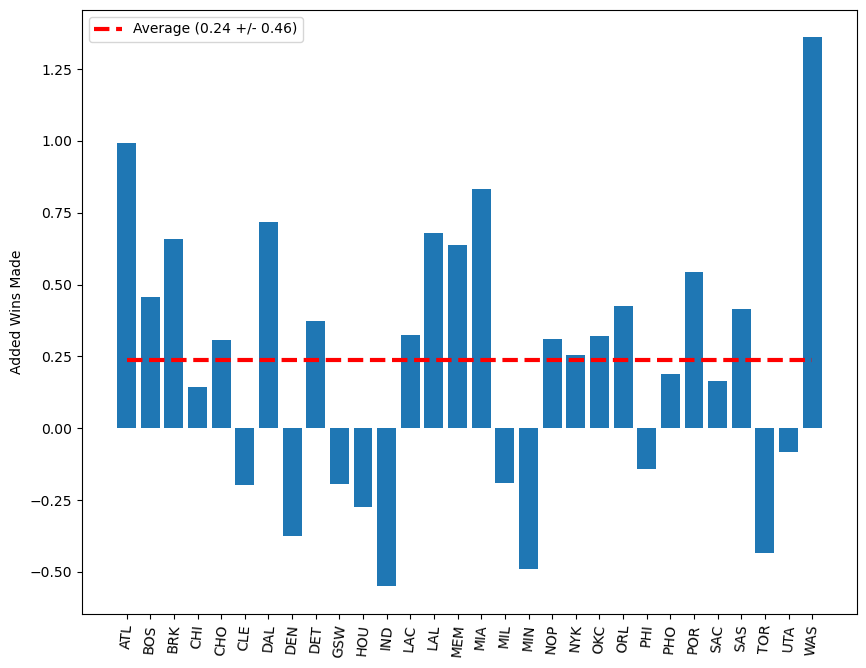

In [18]:
# Create a plot from this!
plt.figure(figsize=(10,8), dpi=100)
labels = resultsData.team.to_numpy()
heights = resultsData.addedWins.to_numpy()
avgHeight = np.mean(heights)
stdHeight = np.std(heights)
print(labels)

x = range(len(labels))
plt.bar(x, heights)
plt.plot([min(x), max(x)], [avgHeight, avgHeight], "--r", linewidth=3, 
         label="Average ({:.2f} +/- {:.2f})".format(avgHeight, stdHeight))
plt.legend()

plt.ylabel("Added Wins Made")
plt.xticks(x, labels, rotation=85)
plt.show()

In [ ]:
# plot the average value
oldWMs = []
newWMs = []
for i in range(len(simData)):
    oldPlayer = simData["oldPick"].iloc[i]
    newPlayer = simData["newPick"].iloc[i]
    
    oldWM = scaledDraft[scaledDraft["Player"]==oldPlayer].iloc[0]["WM"]
    newWM = scaledDraft[scaledDraft["Player"]==newPlayer].iloc[0]["WM"]
    
    if pd.isnull(oldWM) or pd.isnull(newWM):
        continue
    
    oldWMs.append(oldWM)
    newWMs.append(newWM)

In [ ]:
plt.figure(figsize=(5,4), dpi=100)
width = 0.15       # the width of the bars
r1 = width/2.
r2 = -width/2.

plt.bar(r2, [np.mean(oldWMs)], width=width, label="Old Pick Wins Made")
plt.bar(r1, [np.mean(newWMs)], width=width, label="New Pick Wins Made")

plt.ylabel("Wins Made")

plt.legend(loc="lower right")
plt.show()
print("Old Average:", np.mean(oldWMs), "New Average:", np.mean(newWMs))